<a href="https://colab.research.google.com/github/WanjohiChristopher/Zindi-Kenya-Sign-Language-Classification-Hack/blob/main/Kenyan_Sign_LanguageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q  fastai==1.0.61

In [3]:
# check version of fastai
import fastai

fastai.__version__

'1.0.61'

In [4]:
# connect to gdrive
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [5]:
import numpy as np 
import pandas as pd 

from fastai import *
from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:

image_path = '/content/drive/MyDrive/ZindiSignlanguage/Images'

### tfms helps to do data augmentation on the data to have a better pixel values

In [7]:
tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.5,max_zoom=2.0,max_warp=0.2,max_rotate=45)

### Read the data and pass the data augmentation function

In [8]:
df = pd.read_csv("/content/drive/MyDrive/ZindiSignlanguage/Train.csv")

In [9]:
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [10]:
data = ImageDataBunch.from_df(image_path,
                              df,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=5,
                              bs=10,
                             suffix='.jpg').normalize(imagenet_stats)

In [11]:
# There are 9 classes!
print(data.c) 

9


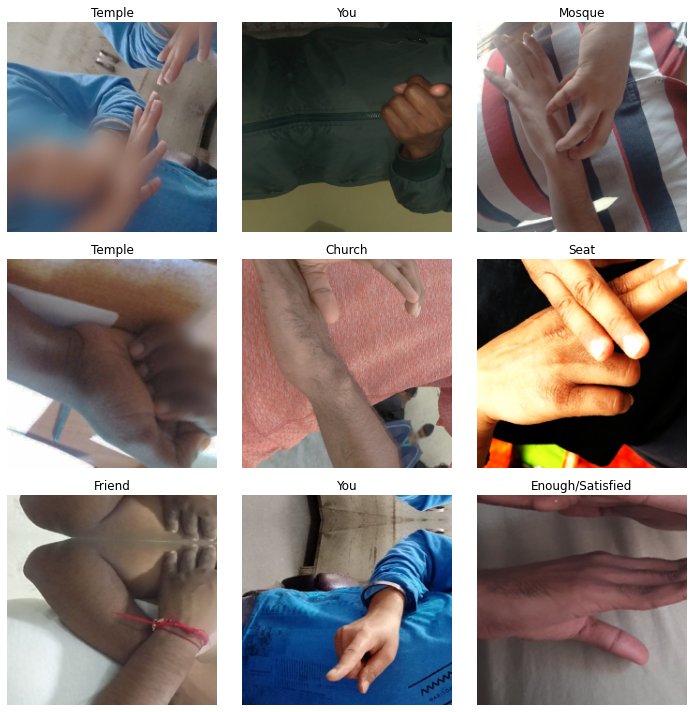

In [12]:
# Look at some examples
data.show_batch(rows=3, figsize=(10, 10)) 

### Modelling
Using Efficientnet Model

In [13]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=80b42ba2dfcfc5ff7da7b3d514e2c0a30ab796f9fed7b1a9b834e9c8ac81179b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [14]:
from efficientnet_pytorch import EfficientNet

In [15]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])
model = EfficientNet.from_name('efficientnet-b0')
#model._fc = nn.Linear(1280, data.c)
#learn = Learner(data, model,metrics=[error_rate, accuracy])
#learn.fit(n_epoch=200, lr=1e-7, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
# Fit
num_epochs =20
learn.fit_one_cycle(num_epochs, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.069273,2.036777,0.730184,0.269816,18:46
1,2.574747,1.557409,0.550040,0.449960,18:22
2,2.147554,1.287334,0.456365,0.543635,18:53
3,1.882636,1.084454,0.368295,0.631705,18:14
4,1.572095,0.961029,0.338671,0.661329,18:16
5,1.441396,0.928772,0.324259,0.675741,19:21
6,1.413540,0.814674,0.279424,0.720576,18:24
7,1.300833,0.783424,0.263411,0.736589,18:19
8,1.334534,0.753849,0.253803,0.746197,18:22
9,1.339492,0.718236,0.241793,0.758207,18:51


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.069273,2.036777,0.730184,0.269816,18:46
1,2.574747,1.557409,0.550040,0.449960,18:22
2,2.147554,1.287334,0.456365,0.543635,18:53
3,1.882636,1.084454,0.368295,0.631705,18:14
4,1.572095,0.961029,0.338671,0.661329,18:16
5,1.441396,0.928772,0.324259,0.675741,19:21
6,1.413540,0.814674,0.279424,0.720576,18:24
7,1.300833,0.783424,0.263411,0.736589,18:19
8,1.334534,0.753849,0.253803,0.746197,18:22
9,1.339492,0.718236,0.241793,0.758207,18:51


## predict on test set

In [17]:
test_df = pd.read_csv("/content/drive/MyDrive/ZindiSignlanguage/Test.csv")

In [18]:
test_df.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [19]:
test = ImageList.from_df(test_df, image_path, suffix='.jpg')

In [20]:
data.add_test(test)

In [21]:
#predictions

In [22]:
preds_test,y_test = learn.get_preds(DatasetType.Test)

In [ ]:
#preds_test[:,i]

In [ ]:
y_test

In [29]:
sub=pd.read_csv('/content/drive/MyDrive/ZindiSignlanguage/SampleSubmission.csv')
k=[]
for col in sub.columns: 
    k.append(col) # creating list of the label

In [30]:
k

['img_IDS',
 'Church',
 'Enough/Satisfied',
 'Friend',
 'Love',
 'Me',
 'Mosque',
 'Seat',
 'Temple',
 'You']

In [31]:
import os
submission = pd.DataFrame()
submission["ID"] = test_df["img_IDS"]
for i, c in enumerate(learn.data.classes):
    print(c)
    submission[c] = preds_test[:,i]
submission.head()

Church
Enough/Satisfied
Friend
Love
Me
Mosque
Seat
Temple
You


,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.022483,0.034002,0.008782,0.000648,0.000908,0.008540,0.002040,0.909971,0.012625
1,ImageID_SZ8D1ZJI,0.032896,0.941137,0.000723,0.000272,0.002384,0.007472,0.000115,0.013605,0.001396
2,ImageID_4OJO2F8J,0.011829,0.001584,0.000003,0.000002,0.000045,0.986094,0.000244,0.000135,0.000064
3,ImageID_IEE4XV0B,0.029344,0.006485,0.000041,0.000099,0.002225,0.941177,0.012318,0.006975,0.001336
4,ImageID_BP0O0WZ9,0.038016,0.006664,0.012818,0.004865,0.028164,0.006658,0.057299,0.107946,0.737569


In [33]:
submission.to_csv('finali.csv', index=False)